# Final Project

**Subject**: Grammy award nominee estimation.

* Harun Lokman Kılıç (kilichar18@itu.edu.tr)
* Serdar Akbulut (serdar.akbulut.1997@gmail.com)


## Dataset
* We have used a dataset from Kaggle that contains Billboard Magazine's weekly Hot 100 lists from 1958 to 2021 ([Kaggle Dataset](https://www.kaggle.com/datasets/dhruvildave/billboard-the-hot-100-songs)). 
* We have used a code that pulls lists from Wikipedia pages to import Grammy nominee lists of the "Record of The Year" category. We have done this as we could not find a proper dataset online that contained Grammy nominees of each year [Gitub Code Link](PUT LINK HERE).

## Goal
Our aim is to analyze the annual Hot 100 data, then add weights to each song based on its importance (calculated by how many weeks the said song has remained in the list; by sum of its ranks during that period; and finally by a ratio that calculates its average rank) and then sort these weights to decide on the most succesful songs of the year and then compare our guesses with the actual Grammy nominees.    

## Libraries
* Pandas was used to create and handle dataframes.
* urlopen was used to make web requests.

## Code

* The first dataset that contains the Hot 100's is pulled in the cell below. Then, a parameter "rankimportance" is created that is calculated by the formula (100/(the song's rank that week)). i.e. The #1 song of the week gets 100 points while the #25 gets 4 points.

In [1]:
import pandas as ps
from urllib.request import urlopen
import matplotlib.pyplot as plt
url = "https://raw.githubusercontent.com/micybusy/sketch/main/charts.csv"
with urlopen(url) as f:
    content = ps.read_csv(url, encoding = "utf-8")
content["rankimportance"]=100/content["rank"]
content.head()

,date,rank,song,artist,last-week,peak-rank,weeks-on-board,rankimportance
0,2021-11-06,1,Easy On Me,Adele,1.0,1,3,100.000000
1,2021-11-06,2,Stay,The Kid LAROI & Justin Bieber,2.0,1,16,50.000000
2,2021-11-06,3,Industry Baby,Lil Nas X & Jack Harlow,3.0,1,14,33.333333
3,2021-11-06,4,Fancy Like,Walker Hayes,4.0,3,19,25.000000
4,2021-11-06,5,Bad Habits,Ed Sheeran,5.0,2,18,20.000000


* A new dataframe, from the one above, is derived, that contains the dates of each song with a seperator. This is done to locate each year as a year for the Grammy is the days between two consecutive Octobers.

In [2]:
date=content['date'].str.split('-', expand=True)
date.rename(columns = {0:'year',1:'month',2:'day'}, inplace = True)
date["year"] = date.year.astype('int')
date["month"] = date.month.astype('int')
date["day"] = date.day.astype('int')
content["year"]=date["year"]; content["month"]=date["month"];
content.loc[(content["month"]>9),'year']=date['year']+1
date.head()

,year,month,day
0,2021,11,6
1,2021,11,6
2,2021,11,6
3,2021,11,6
4,2021,11,6


* We filtered the data using the groupby function of pandas. Then we took the sum of each songs performance for each week by creating the "rankimportance" parameter that is a binary operator that outputs 1 if the song is #1 that week, and 0 if the song is not #1 that week.

In [3]:
content['sumimportance'] = content.groupby(["artist", "song",'year'])['rankimportance'].transform('sum')
content=content.sort_values("sumimportance", ascending = False)
content['rank_1']=0
content["rank_1"]=content["rank"].copy()
content["rank_1"]=content["rank_1"].apply(lambda x:  0 if x>1 else 1)
content['rank_1_sum'] = content.groupby(["artist", "song",'year'])['rank_1'].transform('sum')
content=content.sort_values("rank_1_sum", ascending = False)

* Then, we filter the data by sumimportance and rank_1_sum parameters. After that we created a new parameter called ratio which is the ratio of sumimportance to count.

In [4]:
table=ps.DataFrame(content.groupby(['year','song','artist','sumimportance','rank_1_sum']).size().reset_index().rename(columns={0:'count'}))
table['ratio']=table['sumimportance']/table['count']
table=table.sort_values("sumimportance", ascending = False)

* The code under is to determine how many weeks are in the selected time frame.

In [5]:
tabledate=ps.DataFrame(content.groupby(['year',"date"]).size().reset_index().rename(columns={0:'count'}))
tabledate=tabledate.drop(["count"],axis=1)
tabledatex=ps.DataFrame(tabledate.groupby(['year']).size().reset_index().rename(columns={0:'yeartotalweek'}))

* The code under will be used to determine the week in which the song has first appeared. This is achieved by indexing the weeks of each year, not in the traditional way but by taking the October's first week as the following year's first week.

In [6]:
tabledate["week"]=0
b=0
for i in range(65):
    a=tabledatex.iloc[i,1]
    for j in range(a):
         tabledate.iloc[j+b,2]=j+1
    b=b+a

* Here we merge the date with the sorted data obtained from above.

In [7]:
tabledate=tabledate.drop(["year"],axis=1)
content=content.merge(tabledate,on=['date'], how='left')
content=content.merge(tabledatex,on=['year'], how='left')

* In this part we use the groupby function again to create a data that contains the first week appearence of a song. Then we group all the data together.

In [8]:
content=content.sort_values(["date","rank"], ascending = True)
content["first_test"] = content.groupby(['year','song','artist'])["week"].transform("first")

table=ps.DataFrame(content.groupby(['year','song','artist','sumimportance','rank_1_sum','yeartotalweek','first_test']).size().reset_index().rename(columns={0:'count'}))
table["debut"]=table["yeartotalweek"]-table["first_test"]+1
table['ratio']=table['sumimportance']/table['debut']
table=table.sort_values("ratio", ascending = False)

* The function below takes two integers as its argument: the first one indicates the year that is to be filtered in the original dataset, and the latter indicates how many items from the refined data is to be shown. It basically takes the original data and returns the sorted versions with respect to the columns that we are interested in.

In [9]:
def gettables(y, lines):
    tablex=table.loc[table["year"]==y]
    tablex=tablex.sort_values("ratio", ascending = False)
    tabley=tablex.sort_values("sumimportance", ascending = False)
    tablez = tablex.sort_values("rank_1_sum", ascending = False)
    tablex = tablex.reset_index();
    tabley = tabley.reset_index();
    tablez = tablez.reset_index();
    return {"ratio":tablex[:lines], "sumimp":tabley[:lines], "sum1": tablez[:lines]}

### Example

In [10]:
gettables(2019, 5)

{'ratio':    index  year           song                               artist  \
 0  34000  2019  Old Town Road  Lil Nas X Featuring Billy Ray Cyrus   
 1  34087  2019       Senorita        Shawn Mendes & Camila Cabello   
 2  33625  2019        Bad Guy                        Billie Eilish   
 3  33587  2019        7 Rings                        Ariana Grande   
 4  34186  2019    Truth Hurts                                Lizzo   
 
    sumimportance  rank_1_sum  yeartotalweek  first_test  count  debut  \
 0    2030.381513          19             52          24     29     29   
 1     565.000000           1             52          40     13     13   
 2     912.821068           1             52          28     25     25   
 3    1115.641747           8             52          18     33     35   
 4     613.689090           4             52          33     20     20   
 
        ratio  
 0  70.013156  
 1  43.461538  
 2  36.512843  
 3  31.875478  
 4  30.684455  ,
 'sumimp':    index 

* The function below also takes two integers as its argument with the exact logic above. It also calls the function above, takes its outputs and manipulates them. That is, each row of the important columns of the outputs of the function above is multiplied by a coefficient. The function then returns the multiplied versions.

In [11]:
def assign_weight(year, lines):
    tablo = gettables(year, lines)["ratio"]
    tablo1 = gettables(year, lines)["sumimp"]
    tablo2 = gettables(year, lines)["sum1"]
    tablo["value"] = 0
    tablo1["value"] = 0
    tablo2["value"] = 0
    for i in range(len(tablo)):
        tablo["value"][i] = len(tablo) - i
        tablo1["value"][i] = len(tablo) - i
        tablo2["value"][i] = len(tablo) - i
        
    tablo["value"]=ps.to_numeric(tablo["value"])
    tablo["value"] = tablo["value"]*0.25
    tablo1["value"]=ps.to_numeric(tablo1["value"])
    tablo1["value"] = tablo1["value"]*0.55
    tablo2["value"]=ps.to_numeric(tablo2["value"])
    tablo2["value"] = tablo2["value"]*0.2
    return {"ratio":tablo[:lines], "sumimp":tablo1[:lines], "sum1": tablo2[:lines]}

### Example

In [12]:
%%capture --no-display
assign_weight(2019,5)

{'ratio':    index  year           song                               artist  \
 0  34000  2019  Old Town Road  Lil Nas X Featuring Billy Ray Cyrus   
 1  34087  2019       Senorita        Shawn Mendes & Camila Cabello   
 2  33625  2019        Bad Guy                        Billie Eilish   
 3  33587  2019        7 Rings                        Ariana Grande   
 4  34186  2019    Truth Hurts                                Lizzo   
 
    sumimportance  rank_1_sum  yeartotalweek  first_test  count  debut  \
 0    2030.381513          19             52          24     29     29   
 1     565.000000           1             52          40     13     13   
 2     912.821068           1             52          28     25     25   
 3    1115.641747           8             52          18     33     35   
 4     613.689090           4             52          33     20     20   
 
        ratio  value  
 0  70.013156   1.25  
 1  43.461538   1.00  
 2  36.512843   0.75  
 3  31.875478   0.50  
 4

The function below sums the values obtained from the function above to find a song's total weight, then assigns each song its weight.

In [13]:
def sum_weight(year, lines):
    tables = assign_weight(year, lines)
    [tablo, tablo1, tablo2] = [tables["ratio"], tables["sumimp"], tables["sum1"]]
    evaluate = gettables(year, lines)["sumimp"]
    evaluate = evaluate.sort_values(by = "sumimportance", ascending = False)
    evaluate["weight"] = float(0)
    for i in range(len(evaluate)):
        for j in range(len(tablo)):
            if evaluate["song"][i] == tablo["song"][j]:
                evaluate["weight"][i] += float(tablo["value"][j])
        for k in range(len(tablo1)):
            if evaluate["song"][i] == tablo1["song"][k]:
                evaluate["weight"][i] += float(tablo1["value"][k])
        for l in range(len(tablo2)):
            if evaluate["song"][i] == tablo2["song"][l]:
                evaluate["weight"][i] += float(tablo2["value"][l])
    evaluate = evaluate.reset_index(drop = True)
    return evaluate[:lines]

### Example

In [14]:
%%capture --no-display
sum_weight(2019, 5)

,index,year,song,artist,sumimportance,rank_1_sum,yeartotalweek,first_test,count,debut,ratio,weight
0,34000,2019,Old Town Road,Lil Nas X Featuring Billy Ray Cyrus,2030.381513,19,52,24,29,29,70.013156,5.00
1,34228,2019,Without Me,Halsey,1129.415082,2,52,3,50,50,22.588302,2.20
2,33587,2019,7 Rings,Ariana Grande,1115.641747,8,52,18,33,35,31.875478,2.95
3,34151,2019,"Thank U, Next",Ariana Grande,1026.250891,7,52,7,28,46,22.309802,1.70
4,34130,2019,Sunflower (Spider-Man: Into The Spider-Verse),Post Malone & Swae Lee,996.607078,1,52,5,48,48,20.762647,0.55


The function below takes the output of the function above and simply sorts it based on the "weights" column.

In [15]:
def weight_sort(year, lines):
    evaluate = sum_weight(year,lines)
    evaluate = evaluate.sort_values(by = "weight", ascending = False)
    evaluate = evaluate.reset_index(drop = True)
    return evaluate

### Example

In [16]:
%%capture --no-display
weight_sort(2019,5)

,index,year,song,artist,sumimportance,rank_1_sum,yeartotalweek,first_test,count,debut,ratio,weight
0,34000,2019,Old Town Road,Lil Nas X Featuring Billy Ray Cyrus,2030.381513,19,52,24,29,29,70.013156,5.00
1,33587,2019,7 Rings,Ariana Grande,1115.641747,8,52,18,33,35,31.875478,2.95
2,34228,2019,Without Me,Halsey,1129.415082,2,52,3,50,50,22.588302,2.20
3,34151,2019,"Thank U, Next",Ariana Grande,1026.250891,7,52,7,28,46,22.309802,1.70
4,34130,2019,Sunflower (Spider-Man: Into The Spider-Verse),Post Malone & Swae Lee,996.607078,1,52,5,48,48,20.762647,0.55


We then introduce the dataset that contains the Grammy nominees from 1990 to 2022.

In [17]:
link = "https://raw.githubusercontent.com/micybusy/sketch/main/grammies.csv"
with urlopen(link) as f:
    grammies = ps.read_csv(f, encoding = "utf-8")
grammies = grammies.to_dict()
grammies_fix = {"year": grammies["Year[I]"], "song": grammies["Record"], "artist": grammies["Artist(s)"]}
grammies = ps.DataFrame(grammies_fix)

The function below lets us display the items of the year that we wish to be displayed.

In [18]:
def annual_nominee(year):
    new_df = []
    for i in range(len(grammies)):
        if grammies.iloc[i][0] == year:
            new_df.append(grammies.iloc[i])
    new_df = ps.DataFrame(new_df)
    new_df = new_df.reset_index(drop = True)
    return new_df

### Example

In [19]:
annual_nominee(2015)

,year,song,artist
0,2015,Stay with Me (Darkchild Version),Sam Smith
1,2015,All About That Bass,Meghan Trainor
2,2015,Chandelier,Sia
3,2015,Fancy,Iggy Azalea featuring Charli XCX
4,2015,Shake It Off,Taylor Swift


The function below, finally, lets us compare a year's most succesful songs to that year's Grammy nominees. It then calculates how many of the nominees it attained and gives a clean percentage on the correctness of its guesses.

In [20]:
def compare(x, lines):
    grammy_nominees = annual_nominee(x)
    annual_success = weight_sort(x-1, lines)
    a = 0
    for i in range(lines):
        if annual_success["song"][i] in list(grammy_nominees["song"]):
            a+=1
    percentage = (a/(len(grammy_nominees)))*100
    return percentage

### Example

In [21]:
%%capture --no-display
compare(2010,20)

40.0

## Graphical Representation

The function below draws a graph of the correctness of our estimations on the whole interval. It takes an integer as its argument, which indicates how many items from the top of each year's estimation dataframe we pull search the nominees in. One can intuitively comprehend that the more items we take from those dataframes, the more correct our estimation percentage will be.

In [22]:
def correctness(lines):
    years =[]
    percentages =[]
    for i in range(1990, 2021):
        years.append(i)
        percentages.append(compare(i,lines))
    plt.plot(years, percentages)
    plt.title('Years and Correctness')
    plt.xlabel('Year')
    plt.ylabel('Percentage')
    plt.show()

#### 10 lines of estimation.

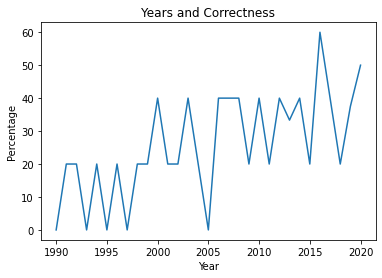

In [23]:
%%capture --no-display
correctness(10)

#### 20 lines of estimation.

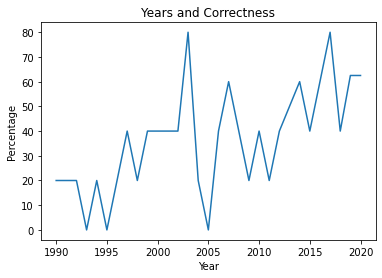

In [24]:
%%capture --no-display
correctness(20)

#### 30 lines of estimation.

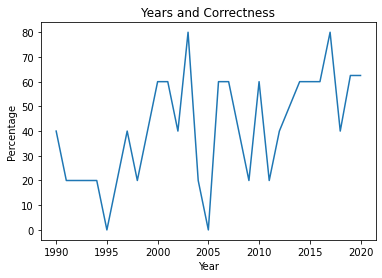

In [25]:
%%capture --no-display
correctness(30)

#### 50 lines of estimation.

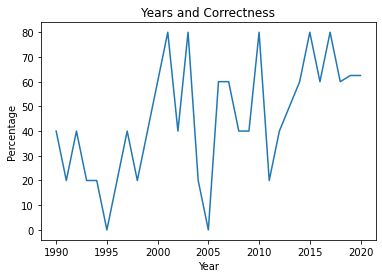

In [26]:
%%capture --no-display
correctness(50)

#### 100 lines of estimation.

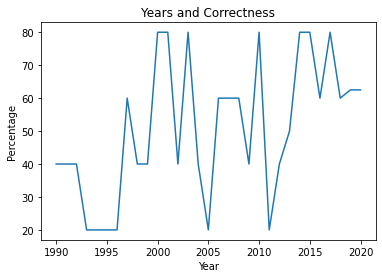

In [27]:
%%capture --no-display
correctness(100)